In [1]:
# Importing all necessary package
import os
import numpy as np
from PIL import Image


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

#A generalist algorithm for cell and nucleus segmentation (v1.0) that can be optimized for your own data (v2.0)
from cellpose.models import Cellpose 
from stardist.models import StarDist2D

from csbdeep.utils import normalize

import tensorflow as tf

from tensorflow import keras
from tensorflow.config import list_physical_devices

# Setting the random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Check if GPU is available
if len(list_physical_devices("GPU")) >= 1:
    use_GPU = True
    tf.config.experimental.set_memory_growth(list_physical_devices("GPU")[0], True)

else:
    use_GPU = False

def load_cellpose():
    """Load the cellpose model and return it"""
    model_c = Cellpose(gpu=use_GPU, model_type="cyto2")
    return model_c


def load_stardist():
    """Load the Stardist model and return it"""
    model_s = StarDist2D.from_pretrained("2D_versatile_he")
    return model_s


def run_cellpose(image, model_cellpose, diameter=None):
    """Run the cellpose model on the image and return the mask"""
    channel = [[0, 0]]
    mask_cellpose, _, _, _ = model_cellpose.eval(
        image, batch_size=1, diameter=diameter, channels=channel
    )
    return mask_cellpose


def run_stardist(image, model_stardist, nms_thresh=0.4, prob_thresh=0.5):
    """Run the stardist model on the image and return the mask"""
    img_norm = image / 255
    img_norm = normalize(img_norm, 1, 99.8)
    mask_stardist, _ = model_stardist.predict_instances(
        img_norm, nms_thresh=nms_thresh, prob_thresh=prob_thresh
    )
    return mask_stardist

model_cellpose = load_cellpose()
model_stardist = load_stardist()

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [2]:
# Load an image, run CellPose to detect muscle fibers and Stardist to detect nuclei.
try:
    from imageio.v2 import imread
except:
    from imageio import imread

img = imread("sample_img/5.jpg")

# CellPose
mask_cellpose = run_cellpose(
    img, model_cellpose)
mask_cellpose = mask_cellpose.astype(np.uint16)
cellpose_mask_filename = "results/sample_he_cellpose_mask.tiff"
Image.fromarray(mask_cellpose).save(cellpose_mask_filename)

# Stardist
mask_stardist = run_stardist(
    img, model_stardist)
mask_stardist = mask_stardist.astype(np.uint16)
stardist_filename = "results/sample_he_stardist_mask.tiff"
Image.fromarray(mask_stardist).save(stardist_filename)

1/1 [==============================] - 5s 5s/step


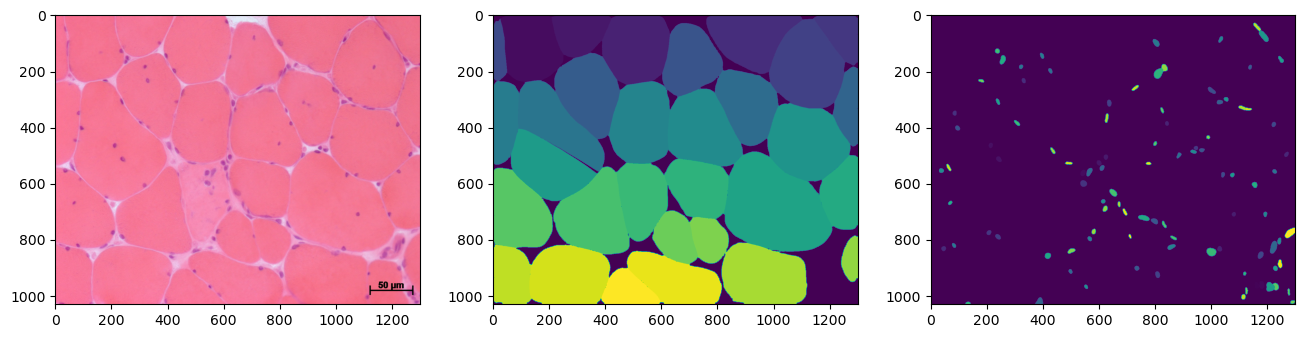

In [6]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,9))
ax1.imshow(img)
ax2.imshow(mask_cellpose)
ax3.imshow(mask_stardist)
plt.show()

In [9]:
# Based on the Cellpose Image and Stardist image we will extract the coordinates of the nuclei and muscle fibers as a table. 
# We will also extract their area in pixels, perimeter, eccentrictiy....
from skimage.measure import regionprops_table
import pandas as pd
props_cellpose = regionprops_table(
    mask_cellpose,
    properties=[
        "label",
        "area",
        "centroid",
        "eccentricity",
        "bbox",
        "image",
        "perimeter",
        "feret_diameter_max"#ajout du diamètre
    ],
)
df_cellpose = pd.DataFrame(props_cellpose)
df_cellpose

,label,area,centroid-0,centroid-1,eccentricity,bbox-0,bbox-1,bbox-2,bbox-3,image,perimeter,feret_diameter_max
0,1,42573,114.372584,134.664435,0.590280,0,26,240,253,"[[False, False, False, False, False, False, Fa...",832.315801,274.417565
1,2,24120,63.611774,308.462935,0.641193,0,209,154,422,"[[False, False, False, False, False, False, Fa...",644.238636,214.200840
2,3,49842,116.046547,510.143514,0.359108,0,388,249,631,"[[False, False, False, False, False, False, Fa...",866.748304,277.650860
3,4,45595,80.636254,917.205220,0.705256,0,760,210,1102,"[[False, False, False, False, False, False, Fa...",951.595021,342.527371
4,5,17997,69.825138,1241.320720,0.798332,0,1143,180,1300,"[[False, False, False, False, False, False, Fa...",592.132034,223.600089
5,6,61886,186.388682,1119.213877,0.568769,11,983,334,1255,"[[False, False, False, False, False, False, Fa...",983.986940,326.167135
6,7,8656,132.348082,20.894177,0.976646,13,0,235,51,"[[False, False, False, False, False, False, Fa...",499.787843,222.324088
7,8,40028,161.908689,702.735685,0.598231,29,602,291,819,"[[False, False, False, False, False, False, Fa...",802.358477,264.850901
8,9,48578,276.923628,340.470563,0.698555,135,219,443,454,"[[False, False, False, False, False, False, Fa...",888.246825,309.657876
9,10,17792,326.442952,1264.944357,0.949231,184,1209,468,1300,"[[False, False, False, False, False, False, Fa...",668.132034,284.112654


In [10]:
df_cellpose.to_csv(r'data_5_jpg.csv', index=False, header=True)

In [90]:
import pandas as pd 
#on importe les fichiers csv nécessaire 
df=pd.read_csv('muscle_atlas_clean.csv') #atlas du muscle
df_cell=pd.read_csv('data_5_jpg.csv') # fichier info image 5 (taille, diamètre, centre...)



def conversion_pix_µm(im, data_frame,muscle_atlas):
    'Convertion du diamètre en µm'
    barre_echelle= muscle_atlas.loc[(df['Number']== im), 'Calibration (um/px)']
    
    data_frame['diameter_µm']=(data_frame['feret_diameter_max'])*barre_echelle.values

conversion_pix_µm('5.jpg',df_cell,df )

def count_atrophic_cells (data_frame,min_size, max_size):
    hyper='Hypertrophy'
    hypo= 'Hypotrophy'
    norm= 'Normal'
    data_frame["State_cell"] = ''
    for index in data_frame.index:
        a=data_frame['diameter_µm'][index]
        if a > max_size:
            data_frame["State_cell"][index]=hyper
        elif a < min_size:
            data_frame["State_cell"][index]=hypo
        else: 
            data_frame["State_cell"][index]= norm


count_atrophic_cells (df_cell, 30, 80)

df_cell

/var/folders/lc/l3h44z2d7_d98lsb5yh9d2y00000gn/T/ipykernel_38021/2662827887.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame["State_cell"][index]=hyper
/var/folders/lc/l3h44z2d7_d98lsb5yh9d2y00000gn/T/ipykernel_38021/2662827887.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame["State_cell"][index]= norm


,label,area,centroid-0,centroid-1,eccentricity,bbox-0,bbox-1,bbox-2,bbox-3,image,perimeter,feret_diameter_max,diameter_µm,State_cell
0,1,42573,114.372584,134.664435,0.590280,0,26,240,253,[[False False False ... False False False]\n [...,832.315801,274.417565,85.618280,Hypertrophy
1,2,24120,63.611774,308.462935,0.641193,0,209,154,422,[[False False False ... False False False]\n [...,644.238636,214.200840,66.830662,Normal
2,3,49842,116.046547,510.143514,0.359108,0,388,249,631,[[False False False ... False False False]\n [...,866.748304,277.650860,86.627068,Hypertrophy
3,4,45595,80.636254,917.205220,0.705256,0,760,210,1102,[[False False False ... False False False]\n [...,951.595021,342.527371,106.868540,Hypertrophy
4,5,17997,69.825138,1241.320720,0.798332,0,1143,180,1300,[[False False False ... False False False]\n [...,592.132034,223.600089,69.763228,Normal
5,6,61886,186.388682,1119.213877,0.568769,11,983,334,1255,[[False False False ... False False False]\n [...,983.986940,326.167135,101.764146,Hypertrophy
6,7,8656,132.348082,20.894177,0.976646,13,0,235,51,[[False False False ... False False False]\n [...,499.787843,222.324088,69.365115,Normal
7,8,40028,161.908689,702.735685,0.598231,29,602,291,819,[[False False False ... False False False]\n [...,802.358477,264.850901,82.633481,Hypertrophy
8,9,48578,276.923628,340.470563,0.698555,135,219,443,454,[[False False False ... False False False]\n [...,888.246825,309.657876,96.613257,Hypertrophy
9,10,17792,326.442952,1264.944357,0.949231,184,1209,468,1300,[[False False False ... False False False]\n [...,668.132034,284.112654,88.643148,Hypertrophy


In [ ]:
#Calculer % de cellules normales, hypertrophiées et hypotrophiées et ensuite les rajouter dans l'atlas du muscle 

In [5]:
#test
print(df_cell['State_cell'].value_counts())

Hypertrophy    23
Normal          8
Name: State_cell, dtype: int64


In [83]:
#test 
percentage= (df_cell['State_cell'].value_counts()/df_cell['State_cell'].count())*100
serie_to_df= pd.Series.to_frame(percentage).transpose()
serie_to_df['Hypotrophy']=0
serie_to_df

,Hypertrophy,Normal,Hypotrophy
State_cell,74.193548,25.806452,0


In [91]:
def pourcentage_state_cell (im,data_frame,muscle_atlas):
     percentage= (data_frame['State_cell'].value_counts()/data_frame['State_cell'].count())*100
     serie_to_df= pd.Series.to_frame(percentage).transpose()
     serie_to_df['Hypotrophy']=0 #faut trouver autre chose la 
     
     ###muscle_atlas["Normal_cell_%"] = ''
     ##muscle_atlas["Hypertrophic_cell_%"] = ''
     #muscle_atlas["Hypotrophic_cell_%"] = ''
     muscle_atlas.loc[(muscle_atlas['Number']== im),"Hypertrophic_cell_%"]=serie_to_df['Hypertrophy'].values
     muscle_atlas.loc[(muscle_atlas['Number']== im),"Normal_cell_%"]=serie_to_df['Normal'].values
     muscle_atlas.loc[(muscle_atlas['Number']== im),"Hypotrophic_cell_%"]=serie_to_df['Hypotrophy'].values


pourcentage_state_cell ('5.jpg',df_cell,df)   

df




,ordered,Number,File name,Organism,muscle,Disease Group,Diag.Final,GENE,Staining method,Age,...,Treatment,SEXE,OMIM,Mutated gene,Excluded Genes,Publication,Link,Hypertrophic_cell_%,Normal_cell_%,Hypotrophic_cell_%
0,5,5.jpg,5 10199 HE-20.jpg,Homo sapiens,deltoid,Muscular Dystrophies,Muscular Dystrophy alpha dystroglycanopathy,FKRP,HE,38y,...,none,F,607155,FKRP mutation homo Leu276Ile,NaN,NaN,NaN,74.193548,25.806452,0.0
1,6,6.jpg,6 10199 SDH-20.jpg,Homo sapiens,deltoid,Muscular Dystrophies,Muscular Dystrophy alpha dystroglycanopathy,FKRP,SDH,38y,...,none,F,607155,FKRP mutation homo Leu276Ile,NaN,NaN,NaN,NaN,NaN,NaN
2,13,13.jpg,13 10202 HE-20.jpg,Homo sapiens,deltoid,Muscular Dystrophies,Muscular Dystrophy alpha dystroglycanopathy,FKRP,HE,39y,...,none,F,607155,FKRP mutation homo Leu276Ile,NaN,NaN,NaN,NaN,NaN,NaN
3,14,14.jpg,14 10202 SDH-20.jpg,Homo sapiens,deltoid,Muscular Dystrophies,Muscular Dystrophy alpha dystroglycanopathy,FKRP,SDH,39y,...,none,F,607155,FKRP mutation homo Leu276Ile,NaN,NaN,NaN,NaN,NaN,NaN
4,21,21.jpg,21 10474 HE-20.jpg,Homo sapiens,quadriceps,Congenital Myopathies,NaN,ASCC1,HE,12 days,...,none,M,616867,ASCC1 mutation homo c.157dupG,ACTA1 CFL2 NEB RYR1 SMN1 TNNT1 TPM2 TPM3 RAS,J Med Genet. 2019; 56(9):617-621,https://jmg.bmj.com/content/56/9/617.long,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,5456,5456.jpg,9825 HE-40.jpg,Homo sapiens,deltoid,Congenital Myopathies,Congenital Myopathy Nemaline,NEB,HE,3y,...,no,M,OMIM: 256030,NEB mutations c.6937C>T (p.Arg2313*) and c.377...,NaN,NaN,NaN,NaN,NaN,NaN
1120,5458,5458.jpg,9825 SDH-20.jpg,Homo sapiens,deltoid,Congenital Myopathies,Congenital Myopathy Nemaline,NEB,SDH,3y,...,no,M,OMIM: 256030,NEB mutations c.6937C>T (p.Arg2313*) and c.377...,NaN,NaN,NaN,NaN,NaN,NaN
1121,5472,5472.jpg,9948 HE-20a.jpg,Homo sapiens,deltoid,Muscular Dystrophies,Calpainopathy (AR),CAPN3,HE,16y,...,no,M,OMIM: 253600,CAPN3 mutations exon 19 c.2105C>T (p.Ala702Val...,NaN,NaN,NaN,NaN,NaN,NaN
1122,5473,5473.jpg,9948 HE-20b.jpg,Homo sapiens,deltoid,Muscular Dystrophies,Calpainopathy (AR),CAPN3,HE,16y,...,no,M,OMIM: 253600,CAPN3 mutations exon 19 c.2105C>T (p.Ala702Val...,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Ajout diamètre moyen des cellules, écart-type 


In [92]:
print(df_cell['diameter_µm'].mean())

89.3582171790665


In [93]:
print(df_cell['diameter_µm'].std())

18.69706987733848


In [97]:
df_cell.describe()



,label,area,centroid-0,centroid-1,eccentricity,bbox-0,bbox-1,bbox-2,bbox-3,perimeter,feret_diameter_max,diameter_µm
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,16.000000,39582.516129,503.006787,625.494737,0.725075,379.096774,517.806452,625.516129,738.322581,804.294927,286.404542,89.358217
std,9.092121,18929.425332,307.216816,402.999155,0.147904,310.006597,399.628529,295.203305,402.716972,185.381443,59.926506,18.697070
min,1.000000,7606.000000,63.611774,20.894177,0.359108,0.000000,0.000000,154.000000,51.000000,395.279221,166.508258,51.950577
25%,8.500000,23775.000000,231.656155,288.966104,0.631269,82.000000,169.500000,388.500000,420.000000,665.912734,250.922593,78.287849
50%,16.000000,42666.000000,453.870776,648.577486,0.713008,314.000000,477.000000,593.000000,731.000000,843.293506,293.552380,91.588343
75%,23.500000,50916.500000,755.733076,939.787382,0.800191,620.500000,801.500000,869.500000,1110.500000,921.278787,318.464348,99.360877
max,31.000000,96953.000000,979.530315,1274.302787,0.976646,901.000000,1240.000000,1030.000000,1300.000000,1256.283405,427.488012,133.376260


In [100]:
def diameter_mean_std (im,data_frame,muscle_atlas):
    cell_mean=data_frame['diameter_µm'].mean()
    cell_std=data_frame['diameter_µm'].std()
    muscle_atlas.loc[(muscle_atlas['Number']== im),"diameter_mean"]=cell_mean
    muscle_atlas.loc[(muscle_atlas['Number']== im),"diameter_std"]=cell_std


diameter_mean_std('5.jpg',df_cell,df)   
df

,ordered,Number,File name,Organism,muscle,Disease Group,Diag.Final,GENE,Staining method,Age,...,OMIM,Mutated gene,Excluded Genes,Publication,Link,Hypertrophic_cell_%,Normal_cell_%,Hypotrophic_cell_%,diameter_mean,diameter_std
0,5,5.jpg,5 10199 HE-20.jpg,Homo sapiens,deltoid,Muscular Dystrophies,Muscular Dystrophy alpha dystroglycanopathy,FKRP,HE,38y,...,607155,FKRP mutation homo Leu276Ile,NaN,NaN,NaN,74.193548,25.806452,0.0,89.358217,18.69707
1,6,6.jpg,6 10199 SDH-20.jpg,Homo sapiens,deltoid,Muscular Dystrophies,Muscular Dystrophy alpha dystroglycanopathy,FKRP,SDH,38y,...,607155,FKRP mutation homo Leu276Ile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13,13.jpg,13 10202 HE-20.jpg,Homo sapiens,deltoid,Muscular Dystrophies,Muscular Dystrophy alpha dystroglycanopathy,FKRP,HE,39y,...,607155,FKRP mutation homo Leu276Ile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14,14.jpg,14 10202 SDH-20.jpg,Homo sapiens,deltoid,Muscular Dystrophies,Muscular Dystrophy alpha dystroglycanopathy,FKRP,SDH,39y,...,607155,FKRP mutation homo Leu276Ile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,21.jpg,21 10474 HE-20.jpg,Homo sapiens,quadriceps,Congenital Myopathies,NaN,ASCC1,HE,12 days,...,616867,ASCC1 mutation homo c.157dupG,ACTA1 CFL2 NEB RYR1 SMN1 TNNT1 TPM2 TPM3 RAS,J Med Genet. 2019; 56(9):617-621,https://jmg.bmj.com/content/56/9/617.long,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,5456,5456.jpg,9825 HE-40.jpg,Homo sapiens,deltoid,Congenital Myopathies,Congenital Myopathy Nemaline,NEB,HE,3y,...,OMIM: 256030,NEB mutations c.6937C>T (p.Arg2313*) and c.377...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1120,5458,5458.jpg,9825 SDH-20.jpg,Homo sapiens,deltoid,Congenital Myopathies,Congenital Myopathy Nemaline,NEB,SDH,3y,...,OMIM: 256030,NEB mutations c.6937C>T (p.Arg2313*) and c.377...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1121,5472,5472.jpg,9948 HE-20a.jpg,Homo sapiens,deltoid,Muscular Dystrophies,Calpainopathy (AR),CAPN3,HE,16y,...,OMIM: 253600,CAPN3 mutations exon 19 c.2105C>T (p.Ala702Val...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122,5473,5473.jpg,9948 HE-20b.jpg,Homo sapiens,deltoid,Muscular Dystrophies,Calpainopathy (AR),CAPN3,HE,16y,...,OMIM: 253600,CAPN3 mutations exon 19 c.2105C>T (p.Ala702Val...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
